# MRI Reconstruction with BART

Based off of previous tutorials from other contributors:  

1. [MRITogether 2023 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2023), [Jon Tamir](mailto:jtamir@utexas.edu), Chandra Family Department of Electrical and Computer Engineering, The University of Texas at Austin
2. [MRITogether 2021 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2021), [Martin Uecker](mailto:uecker@tugraz.at)$^{\dagger}$, Nick Scholand, Moritz Blumenthal, Xiaoqing Wang, $^{\dagger}$Graz University of Technology
3. [BART Webinar 1 Tutorial](https://github.com/mrirecon/bart-webinars/tree/master/webinar1), [Max Litster](mailto:maxlitster@berkeley.edu), UC Berkeley

The purpose of this notebook is to introduce the [BART toolbox](https://mrirecon.github.io/bart), and its use as a tool for reproducible research in MRI.

We recommend checking other points of reference, primarily available in the following locations:
- [BART Workshops](https://github.com/mrirecon/bart-workshop)
- [BART Webinars](https://github.com/mrirecon/bart-webinars) (and [webinar recordings](https://www.youtube.com/@bart-toolboxdepartmental7435/playlists)\)


### Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)
- Set the `BART_TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export BART_TOOLBOX_PATH=/path/to/bart  
export PATH=$BART_TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$BART_TOOLBOX_PATH/matlab` and `$BART_TOOLBOX_PATH/python` directories.

### Online Usage
We recommend running BART locally when possible. For demonstration purposes, MyBinder and Google Colaboratory can be used to access a Jupyter instance with BART with a browser. In the following we install and configure BART for both.

The following code will automatically detect which service you are using.

In [1]:
# Check if notebook runs on colab
import sys, os

os.environ['COLAB'] = 'true' if ('google.colab' in sys.modules) else 'false'

### Google Colab
The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** [here](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/bart_on_colab/colab_gpu_tutorial.ipynb). You can skip this part if you want to run this notebook on your local machine.

This tutorial do need a GPU, you can select one by going to **Edit → Notebook settings**: Choose **GPU** from **Hardware accelerator** drop-down menu.

In [2]:
%%bash

if $COLAB; then
# Why Google?! As of May 13 cuda installed in colab (12.5) is incompatible with the driver (12.4)
# We install cuda 12.4 and link it here but it takes time!

#apt install cuda-12-4
#
#cd /usr/local
#rm cuda
#ln -s cuda-12.4 cuda
#
echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

fi

#### BART Installation

Here we install BARTs dependencies, clone its repository from github, and compile it.

Check BART setup:

In [3]:
%%bash

# MyBinder has BART already installed via the container
if $COLAB; then

  # Install BARTs dependencies
  apt-get install -y -qq make gcc-12 g++-12 libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev

  # Clone Bart
  [ -d /content/bart ] && rm -r /content/bart
  git clone -q https://github.com/mrirecon/bart/ bart
fi

In [4]:
%%bash

if $COLAB; then

cd bart

# Configuration
cat > Makefile.local <<HERE
PARALLEL=1
CUDA=0
CUDA_BASE=/usr/local/cuda
CUDA_LIB=lib64
OPENBLAS=1
BLAS_THREADSAFE=1
CC=gcc-12
HERE

# Compile BART
make --silent && echo ok
fi

#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside an ipyhton jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [5]:
if os.environ['COLAB'] == 'true':
    os.environ['BART_TOOLBOX_PATH'] = "./bart"
    os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']

sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
os.environ['OMP_NUM_THREADS'] = "4"

In [6]:
%%bash
echo "# BART version: "
bart version

# BART version: 
v0.9.00-1174-g9cf7621


### Setup Visualization Helper

For this tutorial we will visualize some images. Therefore, we need a helper function and some python libraries.


In [7]:
# More python libraries
import cfl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

def show_img(data, title=None, vmin=None, vmax=None, cmap='gray', cbar_label='', mag=True, fsize=10):

    # Import data
    data = np.abs(data) if mag else data

    fig = plt.figure(figsize=(fsize,fsize))
    ax1 = fig.add_subplot(111)
    im = ax1.imshow(data, interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    if title:
      plt.title(title)
    # Style settings
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)
    cbar.ax.tick_params()

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_axis_off()

    plt.show()

### Download Supporting Materials
For this tutorial, we also need to download some data from the GitHub repository.

In [8]:
%%bash

# Download the required supporting material if it is not already there
[ ! -f data.zip ] && wget -q https://github.com/mrirecon/bart-workshop/raw/master/mri_together_2023/data.zip
unzip -n data.zip

Archive:  data.zip


## BART Fundamentals
BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation. We can get a list of them by running `bart` with no arguments.

Note: The ! character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.



In [9]:
# get a list of BART commands by running bart with no arguments:
! bart

BART. Type `bart <command> -h` for options.
Basic Tools: bitmask     casorati    circshift   compress    copy        crop        delta       
             extract     flatten     flip        index       join        multicfl    ones        
             poly        repmat      reshape     resize      show        slice       squeeze     
             tee         transpose   trx         vec         version     zeros       
Mathematics: avg         cabs        calc        carg        cdf97       conj        cpyphs      
             creal       fmac        invert      mip         normalize   nrmse       pattern     
             saxpy       scale       sdot        spow        unwrap      zexp        
Numerics:    bench       conv        conway      fft         fftmod      fftrot      fftshift    
             filter      mandelbrot  morphop     nlmeans     noise       pol2mask    roistat     
             rss         std         threshold   var         wavelet     window      
I/O:        

### BART Command Structure

All BART commands are structured in the following way:

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files. To get some information about a command, use the -h flag. Optional arguments are indicated by brackets, and files are indicated by carrot symbols.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [10]:
! bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B                          BART logo
-

The `phantom` tool includes the option `-k` to create it in k-space, and `-x` to specify the size.

## Python Bindings

BART comes equipped with Python bindings that easily integrate with popular scientific computing libraries in Python. This tutorial introduces the structure of the BART python module.

If you're running in MyBinder, the paths should be updated and you should be all set to run the following demos.

If you are running locally, you will need to directly import the bart module. To do this, you can add BART's python directory to your `PYTHONPATH` environment variable. Add the following line to your .bashrc to do this:

```bash
export PYTHONPATH="${BART_TOOLBOX_PATH}/python:$PYTHONPATH"
```

Where `BART_TOOLBOX_PATH` is the location of your BART install.

This way, we can import the bart module as well as cfl, our utility file for dealing with BART's data format: a .hdr header file and a .cfl file of complex-float data.

If you're already running the demo in MyBinder or Colab, this is already setup.


In [11]:
from bart import bart
import cfl

### BART Python Command Structure
The `bart` module allows a user to execute any BART command-line tool via the following format:

```python
<outputs> = bart(<nargout>, <command>, <arguments>, ...)
```
where:
- `<outputs>` are the data file outputs of a BART command
- `<nargout>` is the number of outputs expected by the command
- `<command>` is the command string with flags
- `<arguments>` are the data files passed in for use in the function

Similar to the bash interface, we can also get the help string in a similar way:

In [12]:
bart(0, 'phantom -h')

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B                          BART logo
-

### Create phantoms

We will use the phantom tool to create various types of phantoms

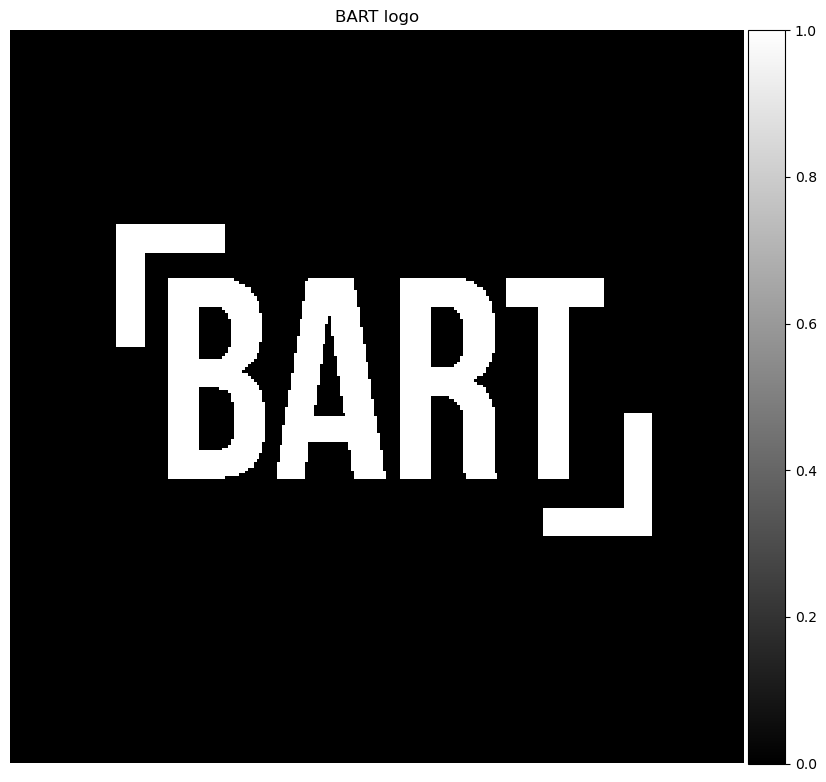

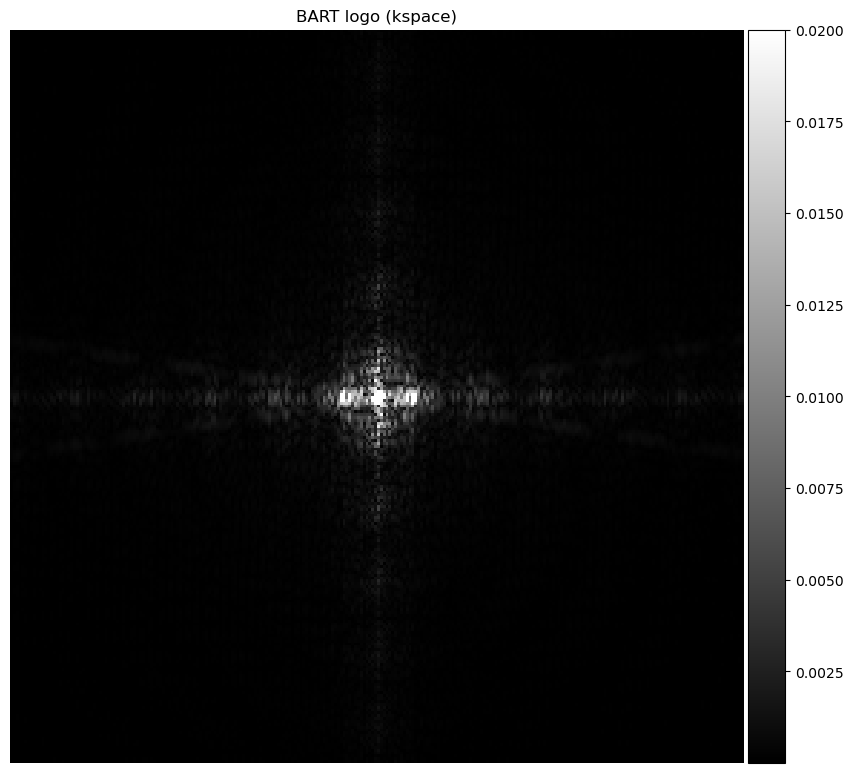

In [13]:
# Create a "BART logo" phantom in the image domain
bart_phantom = bart(1, 'phantom -x 256 -B').T

show_img(bart_phantom, title='BART logo')


# Create a "BART logo" phantom in k-space
bart_phantom_ksp = bart(1, 'phantom -x 256 -B -k').T

show_img(bart_phantom_ksp, title='BART logo (kspace)', vmax=.02)


## File formats and metadata

BART data files are (typically) stored in two files, a header (`.hdr`) file which contains metadata (dimensions, file type, etc.) and a complex float (`.cfl`) file which contains the raw data. The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in col-major order with interleaved real and imaginary components.

A Note about data formats: Saving and loading files are not Python in the purest sense, in that data is not stored in RAM the entire time during execution. Under the hood, the Python bindings are writing .hdr/.cfl files to and from the disk. A RAM disk can be used if users are looking to improve performance in this aspect.

### Writing to and from `.cfl` files

The `cfl` Python library has some helpful tools to save or load BART data into a numpy-compatible format. In the first example, we will create a complex float array in numpy and then load it into BART from the command line. In the second example, we generate an array via the CLI and load it into Python via the cfl library.

In [14]:
A = np.array([1 + 1j, 2 + 3j, 3 + 5j])
cfl.writecfl('A', A)
! ls A.*
! bart show A

A.cfl  A.hdr
+1.000000e+00+1.000000e+00i	+2.000000e+00+3.000000e+00i	+3.000000e+00+5.000000e+00i


Note that when calling BART functions from the command-line, you do not need to include the extension. This is because BART understands to look for both the `.cfl` and `.hdr` files.

In [15]:
! bart ones 2 3 3 B
B = cfl.readcfl('B')
B

array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]], dtype=complex64)

Because the header file is a text file, we can directly print it:

In [16]:
! cat B.hdr

# Dimensions
3 3 
# Command
ones 2 3 3 B 
# Files
 >B
# Creator
BART v0.9.00-1174-g9cf7621


Although not discussed here, BART can write to other file formats that might not have a text header. Thus, it is better to use the show command:

In [17]:
! bart show -m B

Type: complex float
Dimensions: 16
AoD:	3	3	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
followed by other higher order dimensions such as flow encoding, etc.

When using the Python interface, note that higher-order singleton dimensions will be squeezed and thus might not show up as 16-dimensional.

### Using Bitmasks to select dimensions
Let's reconstruct our BART k-space phantom using a inverse Fast Fourier Transform (IFFT). Let's first see the options of the FFT command

In [18]:
!bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output> 

Performs a fast Fourier transform (FFT) along selected dimensions.

-u    unitary
-i    inverse
-n    un-centered
-h    help


The FFT command takes some optional arguments. It then takes three required arguments: `bitmask`, `<input>`, and `<output`>.

We will now export the two Python files and again work mostly with shell commands.

In [19]:
# check the shape of our BART phantom
cfl.writecfl('phantom_img', bart_phantom)
cfl.writecfl('phantom_ksp', bart_phantom_ksp)
!cat phantom_ksp.hdr

# Dimensions
256 256 


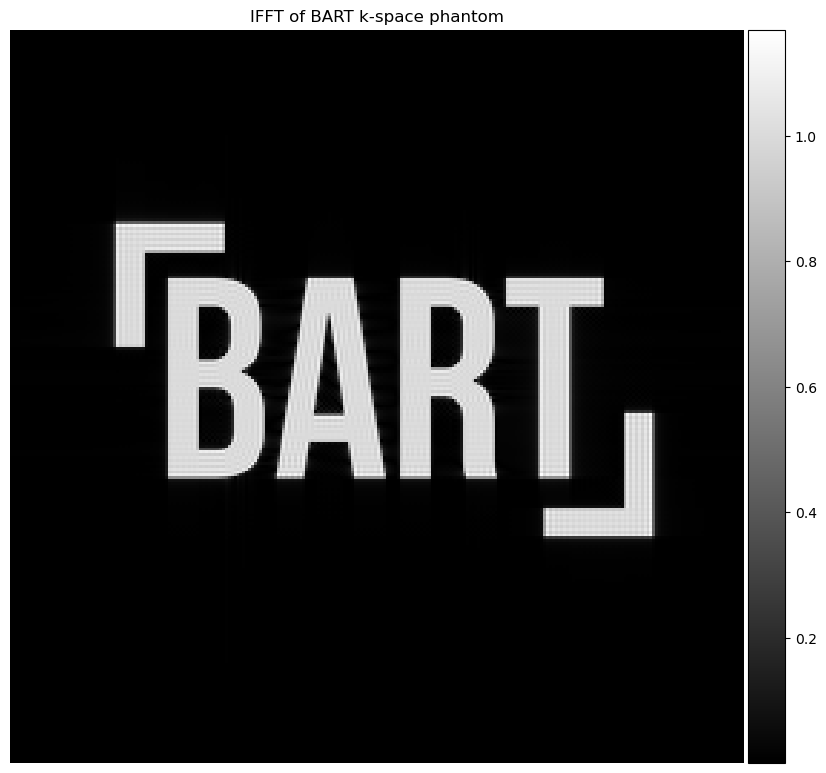

In [20]:
# Perform IFFT reconstruction
!bart fft -i 3 phantom_ksp phantom_rec

show_img(cfl.readcfl('phantom_rec'), 'IFFT of BART k-space phantom')

Thus, we performed an inverse (`-i`) Fast Fourier Transform on the image dimensions **`(0, 1)`** specified by the bitmask **`3`**.


BART loops over dimensions selected by *bitmasks*. This is a powerful approach for perfoming multi-dimensional operations, as most tools will work on arbitrarily chosen dimensions.  

In our case, we wanted to perform an iFFT along dimensions 0 and 1, and the corresponding bitmask is calculated as:  
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [21]:
# Calculate bitmask for active dimensions 0 and 1
! bart bitmask 0 1

3


Let's compare the reconstructed BART phantom to the original image-domain phantom.

First we will create a difference array by subtracting the two images.

Next we will concatenate the  arrays along the second dimension so that we can plot them as one row:


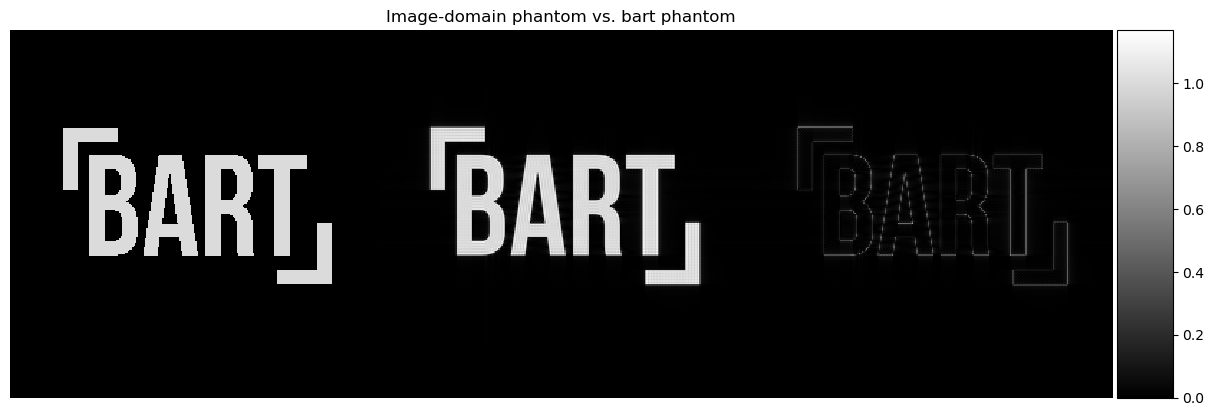

In [22]:
# compute error image
! bart saxpy -- -1. phantom_img phantom_rec phantom_err

# join along second dimension for display
! bart join 1 phantom_img phantom_rec phantom_err phantom_comparison

show_img(cfl.readcfl('phantom_comparison'), title='Image-domain phantom vs. bart phantom', fsize=15)


**Question: why are the two images not identical?**

## BART Examples


### Multi-coil Shepp Logan phantom

A complete tutorial for creating and reconstructing phantom data can be found in the [1st BART Webinar Materials](https://github.com/mrirecon/bart-webinars/blob/master/webinar1/day1_advanced_recon.ipynb)

We start with a simple example that already demonstrates some useful functions in BART:

- Creation of synthetic k-space data using the `phantom` tool
- Creation of subsampling patterns using the `upa` tool
- Calibration of sensitivities using ESPIRIT using the `ecalib` tool
- Parallel imaging reconstruction using the `pics` tool

On the first step, we will create synthetic multi-coil k-space data using the `phantom` tool. We use the '-k' option to specify that we want to simulate k-space data, the -x option to set the matrix size and -s to set the number of coils.

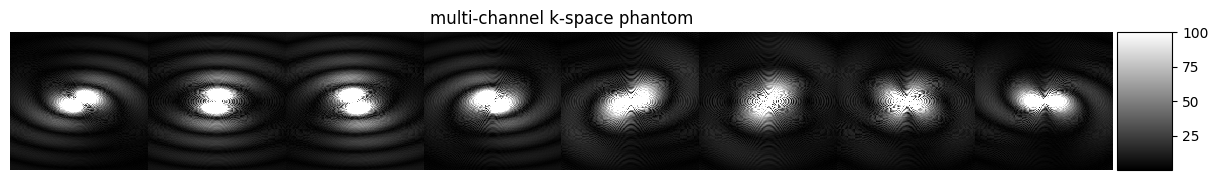

In [90]:
# create fully-sampled Cartesian multi-coil phantom in k-space
! bart phantom -k -x256 -s8 shepp

! bart reshape $(bart bitmask 1 3) $((8 * 256)) 1 shepp sheppR
show_img(cfl.readcfl('sheppR'), title='multi-channel k-space phantom', vmax=100, fsize=15)

Next, we create a subsampling pattern. We can use BART to create sampling patterns suitable for 3D Cartesian imaging using the `poisson` and `upat` commands. We also illustrate how to use a pipe | to directly pass the output to another bart command.

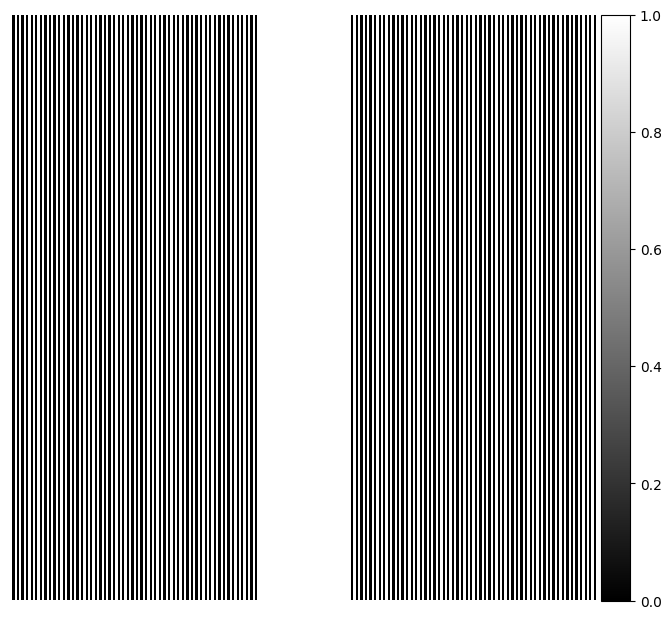

In [91]:
# Create undersampling factor in Y direction and replicate it along X
! bart upat -c20 -Y256 -Z1 -y2 - | bart repmat 0 256 - mask

show_img(cfl.readcfl('mask'), fsize=8)

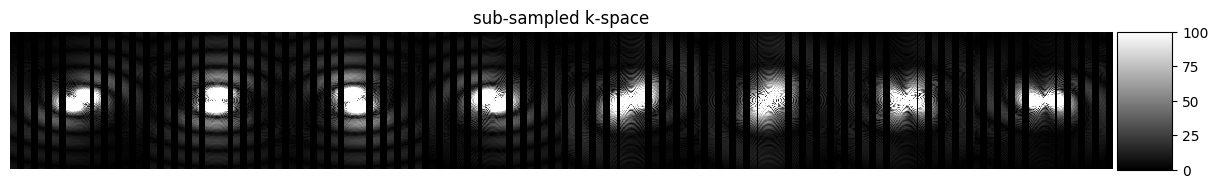

In [92]:
# Multiply kspace data and mask using 'fmac'
! bart fmac shepp mask shepp_upat

! bart reshape $(bart bitmask 1 3) $((8 * 256)) 1 shepp_upat shepp_upatR
show_img(cfl.readcfl('shepp_upatR'), title='sub-sampled k-space', vmax=100, fsize=15)

Note that we used numpy broadcasting to automatically apply the mask to each coil.

After creating the under-sample data, we now first perform a simple reconstruction using an inverse Fourier transform (`fft`) and root-sum-of-squares coil combination (`rss`).

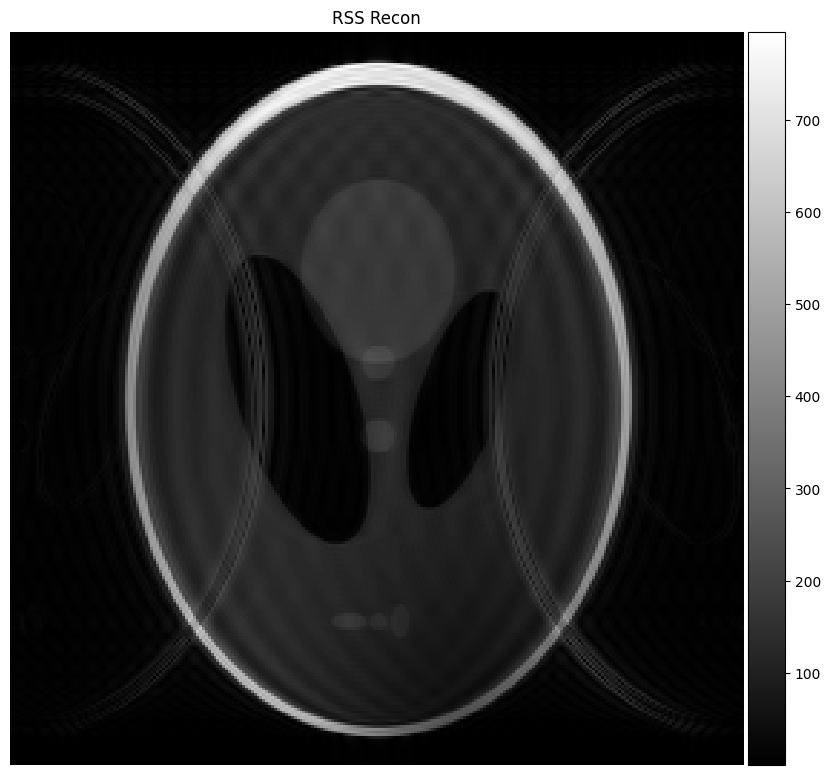

In [93]:
# simple IFFT + RSS reconstruction

# perform inverse FFT. Use the unitary flag for unitary transform
! bart fft -iu 3 shepp_upat shepp_fft

# RSS-combine
! bart rss $(bart bitmask 3) shepp_fft shepp_rss

show_img(cfl.readcfl('shepp_rss'), title='RSS Recon')

The result is (of course) not very good. The image is corrupted with aliasing artifacts due to the equispaced subsampling.

Let's try a more advanced reconstruction technique. We will first determine the coil sensitivities. Here, we use the ESPIRiT algorithm to obtain the sensitivity maps for each coil. We will now have a closer look at the ESPIRiT `ecalib` tool.

In [94]:
! bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-N] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-N               Use phase normalization
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h    

The default number of maps is 2. For simplicity we will only use one set of coil sensitivities in this example by using the option `-m 1`.

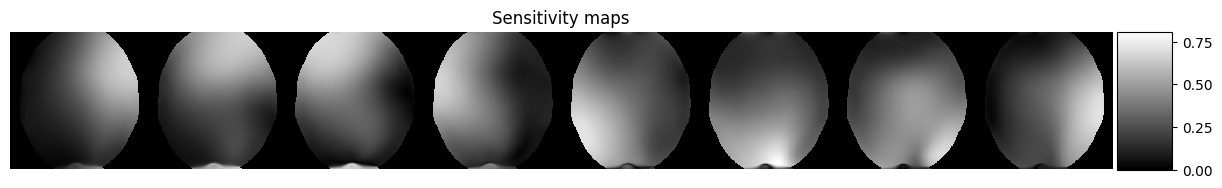

In [95]:
# compute sensitivity maps with ESPIRiT
! bart ecalib -m1 shepp_upat sens_maps

! bart reshape $(bart bitmask 1 3) $((8 * 256)) 1 sens_maps sens_mapsR
show_img(cfl.readcfl('sens_mapsR'), title='Sensitivity maps', fsize=15)

Given the sensitivities, we can use the `pics` command to perform iterative parallel imaging reconstruction using various regularization terms. It solves the folllowing minimization problem:

$\arg\min_x ||PFS x - y|| + \alpha R(x)$, where:
- $P$ is the sampling operator
- $F$ is the Fourier transform
- $S$ is the multiplication with the sensitivity maps
- $x$ is the unknown image
- $y$ are the acquired multi-coil k-space data
- $R$ is a regularization functional
- $\alpha$ is the regularization weighting parameter

A popular regularization is $\ell_2$, i.e. $R(x) = ||x||_2^2$.

The objective function then corresponds to a SENSE reconstruction.

Size: 65536 Samples: 37888 Acc: 1.73
l2 regularization: 0.005000
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.092174


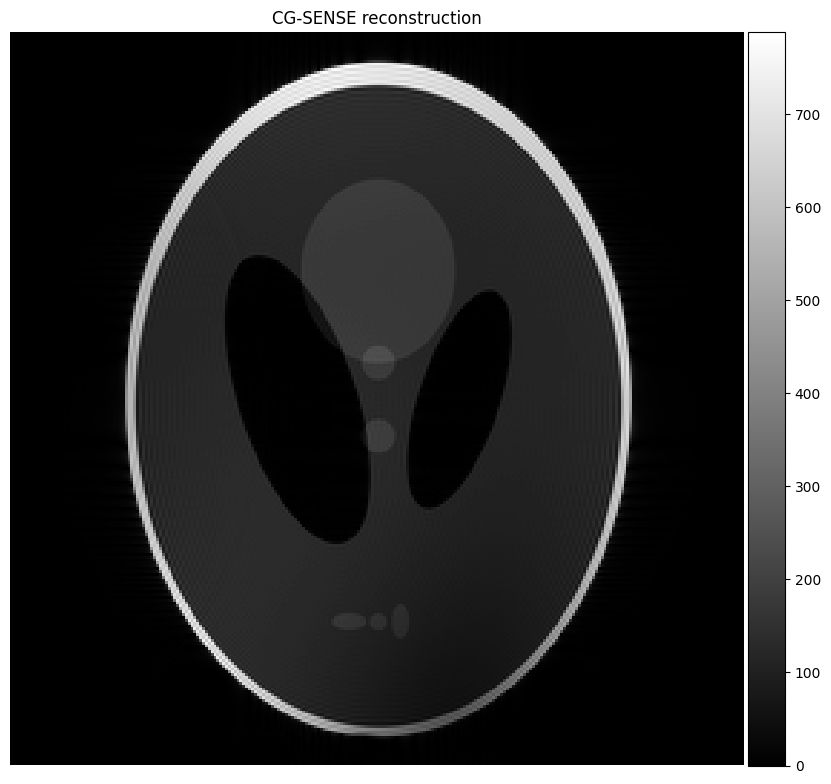

In [96]:
# parallel imaging reconstruction using l2 regularization
! bart pics -S -l2 -r 0.005 -i 50 shepp_upat sens_maps shepp_l2

show_img(cfl.readcfl('shepp_l2'), 'CG-SENSE reconstruction')

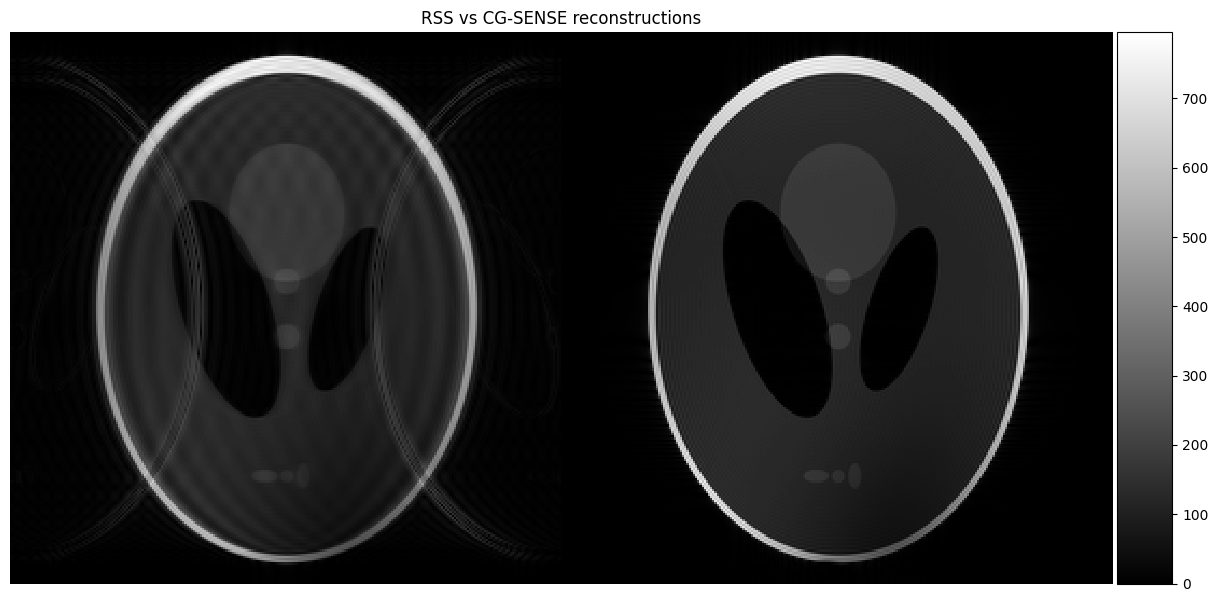

In [97]:
# combine images for display
! bart join 1 shepp_rss shepp_l2 shepp2

show_img(cfl.readcfl('shepp2'), title='RSS vs CG-SENSE reconstructions', fsize=15)

## Reconstructing data from the scanner

Because the BART file format is simple, it is possible to read data from many different sources. The BART command includes the `twixread` tool for basic reading of Siemens `.dat` files. We also include GE Orchestra libraries for reading P-File and ScanArchives, called [ox-bart](https://github.com/mrirecon/ox-bart).

In the data folder, we have already converted a k-space dataset from a vendor-specific format to BART format. The files are the following:

- `ksp`: Raw k-space data
- `ref`: Autocalibration reference scan
- `noise`: Noise pre-scan

We will use all three for reconstruction

In [98]:
%%bash
echo "ksp:"
# use the show command to display dimensions
bart show -m ksp
echo
echo "ref:"
bart show -m ref
echo
echo "noise:"
bart show -m noise

ksp:
Type: complex float
Dimensions: 16
AoD:	768	382	1	16	1	1	1	1	1	1	1	1	1	1	1	1

ref:
Type: complex float
Dimensions: 16
AoD:	768	33	1	16	1	1	1	1	1	1	1	1	1	1	1	1

noise:
Type: complex float
Dimensions: 16
AoD:	768	1	1	16	1	1	1	1	1	1	1	1	1	1	1	1


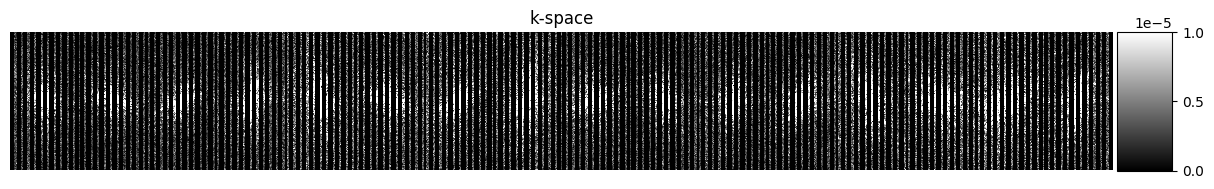

In [99]:
! bart reshape $(bart bitmask 1 3) $((16 * 382)) 1 ksp kspR
show_img(cfl.readcfl('kspR'), title='k-space', vmax=.00001, fsize=15)

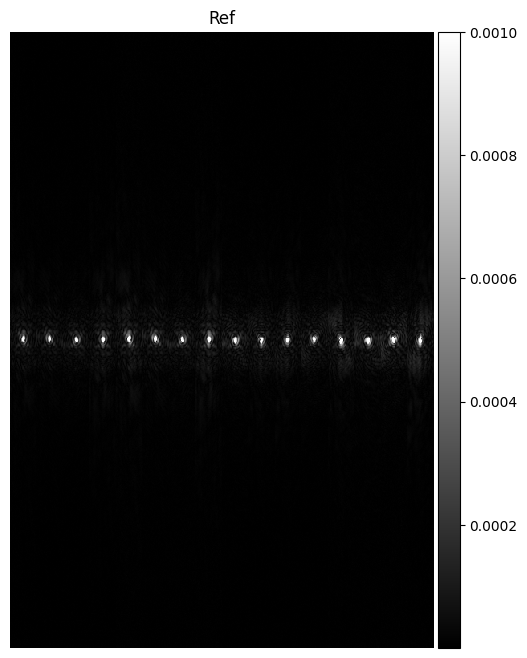

In [100]:
! bart reshape $(bart bitmask 1 3) $((16 * 33)) 1 ref refR
show_img(cfl.readcfl('refR'), title='Ref', vmax=.001, fsize=8)

Based on the array sizes and dimensions, we can infer that the readout dimension is 768 samples, the phase encode dimension is 382, and there are 16 coils. Notice that the reference scan has 33 phase-encode ACS lines.


Our scanner automatically doubles the FOV in the readout dimension.

As first steps, let's (1) crop the data in the readout dimension to FOV/2, and (2) zero-pad the ref data to be the same phase-encode size as the k-space data. Then let's perform IFFTs and look at them in the image domain.

In [101]:
%%bash

# 1. remove the oversampling along readout direction by FFT, resize, and transform back
bart fft -iu 1 ksp - | bart resize -c 0 384 - - | bart fft -u 1 - ksp_crop
bart fft -iu 1 ref - | bart resize -c 0 384 - - | bart fft -u 1 - ref_crop


In [102]:
%%bash

# 2. zero-pad the ref data along phase-encoding size to have the same size has the k-space
bart resize -c 1 382 ref_crop ref_zpad

In [103]:
%%bash

# 3. transform into image domain
bart fft -iu 3 ref_zpad ref_img
bart fft -iu 3 ksp_crop img

Display the images

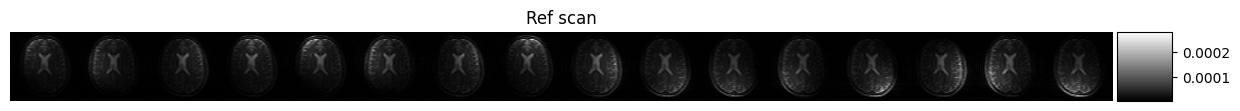

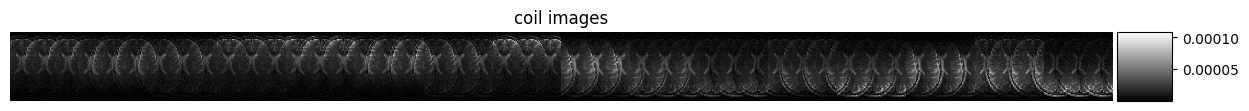

In [104]:
! bart reshape $(bart bitmask 1 3) $((16 * 382)) 1 ref_img ref_imgR
! bart reshape $(bart bitmask 1 3) $((16 * 382)) 1 img imgR
show_img(cfl.readcfl('ref_imgR'), title='Ref scan', fsize=15)
show_img(cfl.readcfl('imgR'), title='coil images', fsize=15)

## Noise pre-whitening
Before reconstruction, it is a good idea to do noise pre-whitening. Most vendors should provide you with a noise pre-scan. If not, then you should complain to your vendor!

For more information about pre-whitening, check out the [ISMRM 2015 Sunrise Course on The Image Reconstruction Pipeline](http://hansenms.github.io/sunrise/) by Michael Hansen.

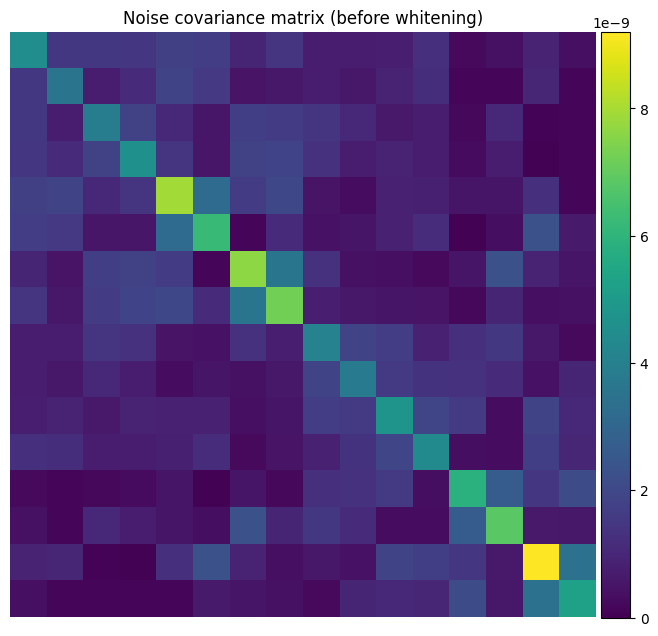

In [105]:
! bart transpose 3 4 noise noiseT
! bart fmac -C -s 1 noise noiseT noise_cov_tmp
! bart squeeze noise_cov_tmp noise_cov

show_img(cfl.readcfl('noise_cov'), cmap='viridis', vmin=0, title='Noise covariance matrix (before whitening)', fsize=8)

We can use the BART `whiten` tool to inspect the covariance matrix and create a noise prewhitening matrix.

In [106]:
! bart whiten -h

Usage: whiten [-o <file>] [-c <file>] [-n] <input> <ndata> <output> [<optmat_out>] [<covar_out>] 

Apply multi-channel noise pre-whitening on <input> using noise data <ndata>.
Optionally output whitening matrix and noise covariance matrix

-o <optmat_in>    use external whitening matrix <optmat_in>
-c <covar_in>     use external noise covariance matrix <covar_in>
-n                normalize variance to 1 using noise data <ndata>
-h                help


In [107]:
! bart whiten -n noise noise noise_white

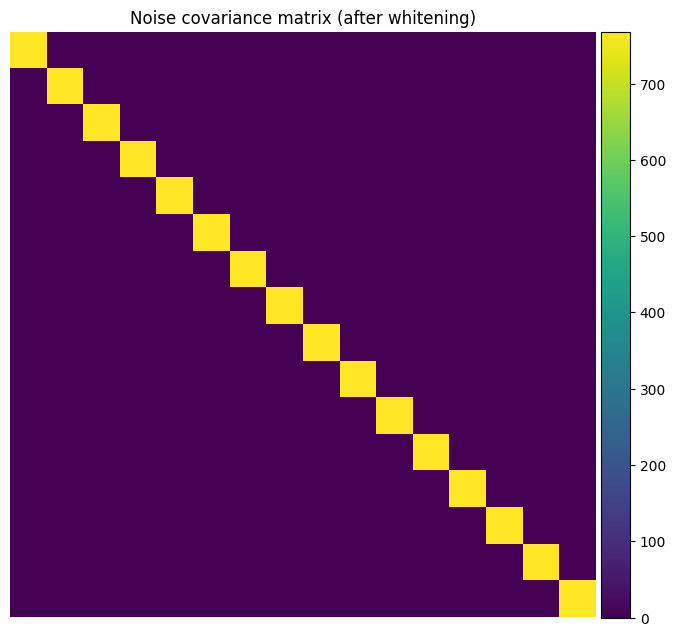

In [108]:
# compute the covariance matrix again
! bart transpose 3 4 noise_white noise_whiteT
! bart fmac -C -s 1 noise_white noise_whiteT - | bart squeeze - noise_white_cov

show_img(cfl.readcfl('noise_white_cov'), cmap='viridis', vmin=0, title='Noise covariance matrix (after whitening)', fsize=8)

Now we can proceed to white the image and the reference k-space.

In [109]:
# whiten kspace
! bart whiten -n ksp_crop noise ksp_white

# whiten reference
! bart whiten -n ref_crop noise ref_white

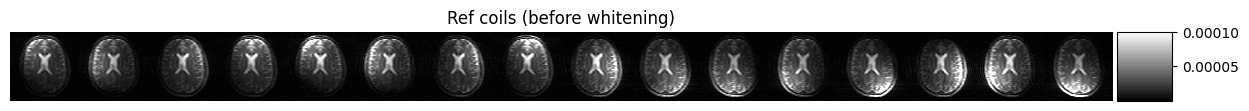

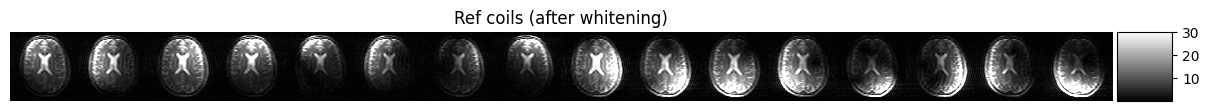

In [110]:
# diplay original reference
! bart fft -iu 3 ref_zpad ref_zpad_img

! bart reshape $(bart bitmask 1 3) $((16 * 382)) 1 ref_zpad_img ref_zpad_imgR
show_img(cfl.readcfl('ref_zpad_imgR'), title='Ref coils (before whitening)', vmax=.0001, fsize=15)

# zero-pad whitened reference
! bart resize -c 1 382 ref_white ref_white_zpad
! bart fft -iu 3 ref_white_zpad ref_white_zpad_img

# display whitened reference
! bart reshape $(bart bitmask 1 3) $((16 * 382)) 1 ref_white_zpad_img ref_white_zpad_imgR
show_img(cfl.readcfl('ref_white_zpad_imgR'), title='Ref coils (after whitening)', vmax=30, fsize=15)

#### Coil Compression
To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command.

We will do coil compression in 2 steps. We will first use `cc` on the reference data to create the coil compression matrix. We will then use ``ccapply` to apply it to both the reference data and to the k-space data. This way we use the same coil compression matrix for both arrays.

By passing `-A` we choose to use all possible data and to reduce the dataset to 8 virtual coils with `-p`.


In [111]:
! bart cc -h

Usage: cc [-p d] [-M] [-r d:d:d] [-A] [-S] [-G] [-E] <kspace> <coeff|proj_kspace> 

Performs coil compression.

-p N    perform compression to N virtual channels
-M      output compression matrix
-r S    size of calibration region
-A      use all data to compute coefficients
-S      type: SVD
-G      type: Geometric
-E      type: ESPIRiT
-h      help


In [112]:
%%bash

# compute coil compression matrix
bart cc -A -M ref_white cc_mat

# apply it to kspace and reference data
bart ccapply -p 8 ref_white cc_mat ref_white_cc
bart ccapply -p 8 ksp_white cc_mat ksp_white_cc

bart show -m ksp_white
bart show -m ksp_white_cc


Type: complex float
Dimensions: 16
AoD:	384	382	1	16	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	384	382	1	8	1	1	1	1	1	1	1	1	1	1	1	1


#### RSS reconstructions
Let's do simple RSS reconstructions of the reference and subsampled data

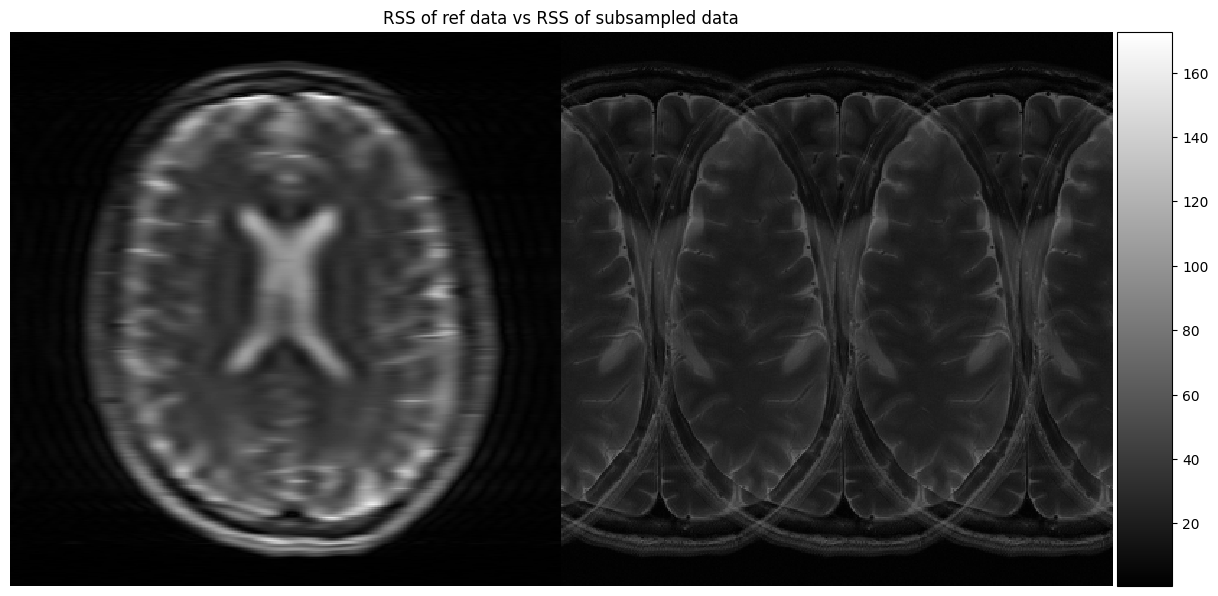

In [113]:
! bart resize -c 1 382 ref_white_cc ref_white_cc_zpad
! bart fft -iu 3 ref_white_cc_zpad - | bart rss $(bart bitmask 3) - ref_rss
! bart fft -iu 3 ksp_white_cc - | bart rss $(bart bitmask 3) - ksp_rss
! bart join 1 ref_rss ksp_rss rss2

show_img(cfl.readcfl('rss2'), title='RSS of ref data vs RSS of subsampled data', fsize=15)

#### Coil Sensitivity Estimation

The coil profile estimation is similar to the case with the phantom data, except it is  applied to the ref scan.

In [114]:
# estimate coil sensitivities
! bart ecalib -m1 ref_white_cc_zpad sens_maps

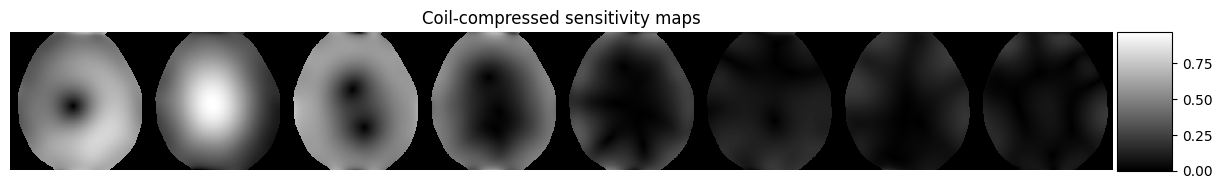

In [115]:
# display the coils
! bart reshape $(bart bitmask 1 3) $((8 * 382)) 1 sens_maps sens_mapsR
show_img(cfl.readcfl('sens_mapsR'), title='Coil-compressed sensitivity maps', fsize=15)

#### Parallel imaging reconstruction
We again use `pics` with l2 regularization. This time we pass an approximate scale factor directly to the `pics` command.

In [116]:
! bart pics -d4 -l2 -r0.0015 -w100. ksp_white_cc sens_maps reco

Size: 146688 Samples: 49151 Acc: 2.98
Inverse scaling of the data: 100.000000
l2 regularization: 0.001500
Regularization terms: 1, Supporting variables: 0
conjugate gradients
	 cg:  30
Total Time: 1.898895


#### Visualize reconstruction

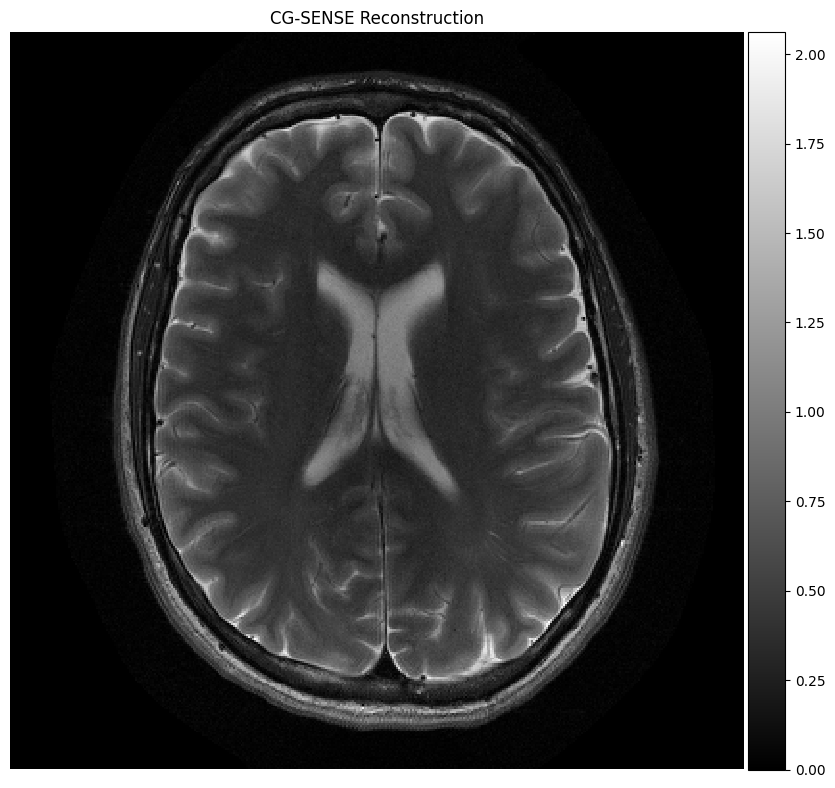

In [117]:
show_img(cfl.readcfl('reco'), title='CG-SENSE Reconstruction')

__Thank you for completing this tutorial!__